In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
# ! pip install "pandas<2.0.0"
data_file = "data/lower-colorado/data.pk"
with open(data_file, 'rb') as file_name:
      df,labels,G_true = pickle.load(file_name)

from sortnregress_time import (
    sortnregress_ts,
    r2_sortnregress_ts,
    r2_sort_regress,
    random_sortnregress_ts,
    random_sort_regress,
    sortnregress,
)

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import tigramite.data_processing as pp

import tigramite.data_processing as pp
from typing import List, Tuple
import numpy as np
import scipy.linalg as slin
from scipy.ndimage import shift
import scipy.optimize as sopt
import warnings

from tigramite import plotting as tp
import matplotlib.pyplot as plt
import networkx as nx

In [11]:
import random


def assign_reviewers(members):
    num_members = len(members)
    # Shuffle the list of members to randomize the assignments
    random.shuffle(members)

    # Create a list to store the pairings
    pairings = []

    # Assign reviewers
    for i in range(num_members):
        # Select a random member to review
        reviewer = random.choice(members[:i] + members[i + 1 :])
        pairings.append((members[i], reviewer))

    return pairings


# Example list of members
members = ["Chris", "Katie", "Angela", "Lucas", "Felizien"]
# Assign reviewers
pairings = assign_reviewers(members)

# Print the pairings
for pair in pairings:
    print(f"{pair[0]} will review the assignment of {pair[1]}")

Lucas will review the assignment of Angela
Angela will review the assignment of Felizien
Chris will review the assignment of Angela
Felizien will review the assignment of Angela
Katie will review the assignment of Chris


In [2]:
def _get_lags(X, tau_max):
    #  Xlags (np.ndarray): shifted data of X with lag orders stacking horizontally. Xlags=[shift(X,1)|...|shift(X,p)]
    Xlags = np.array(
        [
            shift(X, shift=[-i, 0], cval=np.nan)[: -tau_max + 1, :]
            for i in range(1, tau_max + 1)
        ]
    )
    T = X.shape[0]
    Xlags = np.moveaxis(Xlags, 0, 1)
    Xlags = np.moveaxis(Xlags, -1, 1)
    # Xlags = Xlags.reshape(Xlags.shape[0], Xlags.shape[1] * Xlags.shape[2])
    X = X[: T - (tau_max), :]
    Xlags = Xlags[: T - (tau_max), :, :]

    XY = np.zeros((Xlags.shape[0], X.shape[1], tau_max + 1))
    XY[:, :, 0] = X
    XY[:, :, 1:] = Xlags

    return XY

In [3]:
from sklearn.linear_model import LassoLarsIC, LinearRegression


def sortnregress_reverse(X):
    """Take n x d data, order nodes by marginal variance and
    regresses each node onto those with lower variance, using
    edge coefficients as structure estimates."""
    LR = LinearRegression()
    LL = LassoLarsIC(criterion="bic")

    d = X.shape[1]
    W = np.zeros((d, d))
    increasing = np.argsort(np.var(X, axis=0))[::-1]

    for k in range(1, d):
        covariates = increasing[:k]
        target = increasing[k]

        LR.fit(X[:, covariates], X[:, target].ravel())
        weight = np.abs(LR.coef_)
        LL.fit(X[:, covariates] * weight, X[:, target].ravel())
        W[covariates, target] = LL.coef_ * weight

    return W


def sortnregress_ts_reverse(X, tau_max=3):
    LR = LinearRegression()
    LL = LassoLarsIC(criterion="bic", fit_intercept=True)
    XY = _get_lags(X, tau_max=tau_max)
    d = X.shape[1]
    W = np.zeros((d, d, tau_max + 1))
    increasing = np.argsort(np.var(X, axis=0))[::-1]

    for k in range(1, d):
        target = increasing[k]
        indices = increasing[:k]
        x = XY[:, indices, 1:]
        x_shape = x.shape
        x_self = XY[:, k, 1:]
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2]))
        x = np.concatenate((x, x_self), axis=1)
        LR.fit(x, XY[:, target, 0].ravel())
        weight = np.abs(LR.coef_)
        LL.fit(
            x * weight,
            XY[:, target, 0].ravel(),
        )
        weights = LL.coef_ * weight
        W[indices, target, 1:] = weights[: x_shape[1] * x_shape[2]].reshape(x_shape[1:])
        W[target, target, 1:] = weights[x_shape[1] * x_shape[2] :].reshape(
            1, x_shape[2]
        )
    return W

In [4]:
def _get_lags(dataframe, tau_max):
    X = dataframe.values[0].copy()
    #  Xlags (np.ndarray): shifted data of X with lag orders stacking horizontally. Xlags=[shift(X,1)|...|shift(X,p)]
    Xlags = np.array(
        [
            shift(X, shift=[-i, 0], cval=np.nan)[: -tau_max, :]
            for i in range(1, tau_max)
        ]
    )
    Xlags = np.moveaxis(Xlags, 0, 1)
    Xlags = Xlags.reshape(Xlags.shape[0], Xlags.shape[1] * Xlags.shape[2])
    X = X[: -tau_max, :]

    return X, Xlags

In [5]:
df = df.sort_index()

df = df.dropna()

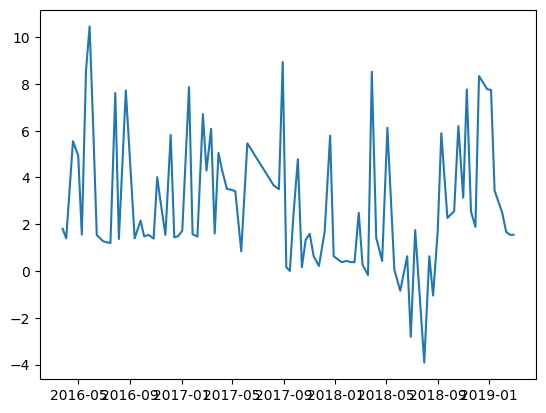

In [6]:
plt.plot(df[5])

In [7]:
from sortability_ts import (
    ts_varsortability,
    var_sortability,
    r2_sortability,
    ts_varsortability,
)

In [6]:
G_true

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0.,

In [8]:
df.to_numpy().shape

(92, 21)

In [9]:
rivers = [
    "danube",
    "lower-colorado",
    "middle-colorado",
    "upper-colorado",
]


In [9]:
results = pd.DataFrame()

In [10]:
rivers

['danube', 'lower-colorado', 'middle-colorado', 'upper-colorado']

In [11]:
from tigramite.independence_tests.parcorr import ParCorr

import numpy as np
parcorr = ParCorr(
    significance="analytic",
    #                   mask_type='y'
)

In [12]:
def ts_graph_to_summary_graph(ts_graph):
    sum_adj = np.sum(ts_graph, axis=2)

    sum_adj[sum_adj != 0] = 1
    np.fill_diagonal(sum_adj, 0)

    return sum_adj

In [30]:
# import auc

from sklearn.metrics import auc, roc_curve
# ignorre warnings
import warnings
warnings.filterwarnings("ignore")
# import tqdm
from tqdm import tqdm

In [60]:
from sklearn.metrics import f1_score
from dynotears import Dynotears
import networkx as nx

r2s = []
vars = []
f1s_var_sortnregress = []
f1s_var_sortnregress_reverse = []
f1s_r2_sortnregress = []
f1s_random = []
f1s_pcmci = []

tau_max = 4

for river in tqdm(rivers):
    data_file = f"data/{river}/data.pk"
    with open(data_file, "rb") as file_name:
        print(data_file)
        df, labels, G_true = pickle.load(file_name)
        df = df.dropna()
        vars.append(var_sortability(df.to_numpy(), G_true))

        r2s.append(r2_sortability(df.to_numpy(), G_true))
        data = df.to_numpy()
        dataframe = pp.DataFrame(data)
        pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)
        results_pcmci = pcmci.run_pcmciplus(tau_max=3, pc_alpha=0.01)
        results_pcmci["p_matrix"] = np.where(
        results_pcmci["p_matrix"] < 0.01, results_pcmci["p_matrix"], 0)
        a_pcmci = results_pcmci["p_matrix"]
        a_pcmci[a_pcmci != 0] = 1

        a_pcmci = ts_graph_to_summary_graph(a_pcmci)

        a_est_var_sortnregress = sortnregress_ts(data, tau_max=tau_max)

        a_est_var_sortnregress_reverse = sortnregress_ts_reverse(data, tau_max=tau_max)
        a_est_r2_sortnregress = r2_sortnregress_ts(data, tau_max=tau_max)
        a_est_var_sortnregress[:, :, 0] = sortnregress(data)
        a_est_var_sortnregress_reverse[:, :, 0] = sortnregress_reverse(data)
        a_est_r2_sortnregress[:, :, 0] = r2_sort_regress(data)
        a_est_random = random_sortnregress_ts(data, tau_max=tau_max)
        a_est_random[:, :, 0] = random_sort_regress(data)

        a_est_var_sortnregress = ts_graph_to_summary_graph(a_est_var_sortnregress)

        a_est_var_sortnregress_reverse = ts_graph_to_summary_graph(a_est_var_sortnregress_reverse)

        a_est_r2_sortnregress = ts_graph_to_summary_graph(a_est_r2_sortnregress)

        a_est_random = ts_graph_to_summary_graph(a_est_random)

        # replace all values above !=0 with 1
        a_est_var_sortnregress[a_est_var_sortnregress != 0] = 1
        a_est_r2_sortnregress[a_est_r2_sortnregress != 0] = 1
        a_est_random[a_est_random != 0] = 1
        f1_var_sortnregress = f1_score(
            G_true.flatten(), a_est_var_sortnregress.flatten()
        )

        f1_var_sortnregress_reverse = f1_score(
            G_true.flatten(), a_est_var_sortnregress_reverse.flatten()
        )
        f1_r2_sortnregress = f1_score(G_true.flatten(), a_est_r2_sortnregress.flatten())
        f1_random = f1_score(G_true.flatten(), a_est_random.flatten())
        f1_pcmci = f1_score(G_true.flatten(), a_pcmci.flatten())

        f1s_var_sortnregress.append(f1_var_sortnregress)
        f1s_r2_sortnregress.append(f1_r2_sortnregress)
        f1s_random.append(f1_random)
        f1s_pcmci.append(f1_pcmci)
        f1s_var_sortnregress_reverse.append(f1_var_sortnregress_reverse)
       


# results["auc_dynotears"] = aucs_dynotears

  0%|          | 0/4 [00:00<?, ?it/s]

data/danube/data.pk


 25%|██▌       | 1/4 [01:23<04:10, 83.58s/it]

data/lower-colorado/data.pk


 50%|█████     | 2/4 [01:25<01:10, 35.48s/it]

data/middle-colorado/data.pk


 75%|███████▌  | 3/4 [01:32<00:22, 22.48s/it]

data/upper-colorado/data.pk


100%|██████████| 4/4 [01:37<00:00, 24.31s/it]


In [61]:
results["river"] = rivers
results["var-sortability"] = vars
results["$r^2$-sortability"] = r2s
results["f1_var_sortnregress"] = f1s_var_sortnregress
results["f1_var_sortnregress_reverse"] = f1s_var_sortnregress_reverse
results["f1_r2_sortnregress"] = f1s_r2_sortnregress
results["f1_random"] = f1s_random
results["f1_pcmci"] = f1s_pcmci

In [64]:
results

# round 4 decimals
results = results.round(4)


results

river  var-sortability  $r^2$-sortability  f1_var_sortnregress  \
0           danube           0.0705             0.8205               0.0811   
1   lower-colorado           0.3485             0.6136               0.0863   
2  middle-colorado           0.2941             0.9412               0.0968   
3   upper-colorado           0.4286             0.9524               0.2632   

   f1_r2_sortnregress  f1_random  f1_pcmci  f1_var_sortnregress_reverse  
0              0.1739     0.1057    0.5581                       0.1961  
1              0.0800     0.0993    0.3636                       0.0752  
2              0.2623     0.2169    0.2564                       0.2333  
3              0.3000     0.2222    0.4118                       0.1081